Please input your investment amount: 10000
  symbol                       company_name  last_price   volume
0   WISH                  ContextLogic Inc.       13.50  326.006
1   TRCH  Torchlight Energy Resources, Inc.        9.92  371.420
4   GSAT                   Globalstar, Inc.        1.51  155.832
  symbol                       company_name  last_price   volume
1   TRCH  Torchlight Energy Resources, Inc.        9.92  371.420
4   GSAT                   Globalstar, Inc.        1.51  155.832
Epoch 1/5
69/69 [==============================] - 10s 44ms/step - loss: 0.0083
Epoch 2/5
69/69 [==============================] - 3s 43ms/step - loss: 0.0027: 0s - loss: 0
Epoch 3/5
69/69 [==============================] - 3s 41ms/step - loss: 0.0023
Epoch 4/5
69/69 [==============================] - 3s 41ms/step - loss: 0.0025
Epoch 5/5
69/69 [==============================] - 3s 49ms/step - loss: 0.0021


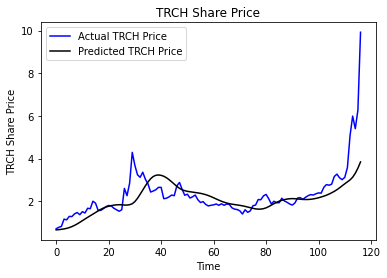

Epoch 1/5
69/69 [==============================] - 8s 40ms/step - loss: 0.0093
Epoch 2/5
69/69 [==============================] - 3s 44ms/step - loss: 0.0039
Epoch 3/5
69/69 [==============================] - 3s 46ms/step - loss: 0.0031
Epoch 4/5
69/69 [==============================] - 3s 44ms/step - loss: 0.0031
Epoch 5/5
69/69 [==============================] - 3s 43ms/step - loss: 0.0029


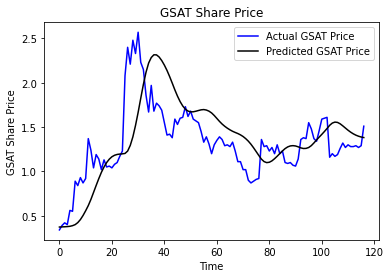

TRCH:
4.2498217
9.92
GSAT:
1.3834957
1.51
TRCH Action: SELL
GSAT Action: SELL


In [90]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import pandas_datareader as web
import datetime as dt


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

predicted_values = []
def predict_stock(option):

        # Load Data\
        company = option
        start = dt.date(2012, 1, 1)
        end = dt.date(2021, 1, 1)
        data = web.DataReader(company, 'yahoo', start, end)
        # Prepare Data
        scaler = MinMaxScaler(feature_range=(0, 1))

        # predict closing price
        scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

        x_train = []
        y_train = []

        prediction_days = 60

        for x in range(prediction_days, len(scaled_data)):
            x_train.append(scaled_data[x-prediction_days:x, 0])
            y_train.append(scaled_data[x, 0])

        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        # MODEL
        model = Sequential()

        model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(x_train, y_train, epochs=5, batch_size=32)


        # Test model accuracy
        ''' In this section we test accuracy against the newer data from 1/1/2020 to the current date'''

        # Load data
        test_start = dt.date(2021, 1, 1)
        test_end = dt.datetime.now()
        test_data = web.DataReader(company, 'yahoo', test_start, test_end)

        actual_prices = test_data['Close'].values

        total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)
        model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
        model_inputs = model_inputs.reshape(-1, 1)
        model_inputs = scaler.transform(model_inputs)

        # Make Predictions
        x_test = []

        for x in range(prediction_days, len(model_inputs)):
            x_test.append(model_inputs[x-prediction_days:x, 0])

        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

        predicted_prices = model.predict(x_test)
        predicted_prices = scaler.inverse_transform(predicted_prices)

        # plot
        
        plt.plot(actual_prices, color="blue", label=f"Actual {company} Price")
        plt.plot(predicted_prices, color="black", label=f"Predicted {company} Price")
        plt.title(f"{company} Share Price")
        plt.xlabel('Time')
        plt.ylabel(f'{company} Share Price')
        plt.legend()
        plt.show()
        
        # predicting the next move
        real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
        real_data = np.array(real_data)
        real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

        prediction = model.predict(real_data)
        prediction = scaler.inverse_transform(prediction)
        predicted_values.append(prediction)

        
import main
ticker_list = main.main()

# remove WISH because not enough data
ticker_list = ticker_list[ticker_list['symbol'] != 'WISH'] 
print(ticker_list)

for i in ticker_list['symbol']:
    predict_stock(i)
    
predicted_price = pd.DataFrame(predicted_price)
ticker_list = pd.DataFrame(ticker_list)
counter = 0

for predicted_price in predicted_values:
    
    print(ticker_list.iloc[counter][0] + ':')
    print(predicted_price[0][0])
    print(ticker_list.iloc[counter][2])
    counter +=1

counter_2 = 0
for predicted_price in predicted_values:
    temp_price = predicted_price[0][0]
    temp_symbol = ticker_list.iloc[counter_2][0] 
    
    if(temp_price > ticker_list.iloc[counter_2][2]):
        print(temp_symbol + " Action: BUY")
    else:
        print(temp_symbol + " Action: SELL")
    counter_2 +=1